라이브러리 실행

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import modi
import time

from ai_camera import AICamera
# import firebase_admin
# from firebase_admin import credentials
# from firebase_admin import firestore

bundle = modi.MODI()

print('bundle finish')


Running PyMODI (v0.9.2)
Cannot validate running PyMODI(v0.9.2), please check your internet connection
Run Can Task.
Start initializing connected MODI modules
Motor (2606) has been connected!
Network (2557) has been connected!
MODI modules are initialized!
bundle finish


Process ConnProc-1:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/pi/.local/lib/python3.7/site-packages/pymodi-0.9.2-py3.7.egg/modi/_conn_proc.py", line 63, in run
    recv_thread.join()
  File "/usr/lib/python3.7/threading.py", line 1032, in join
    self._wait_for_tstate_lock()
  File "/usr/lib/python3.7/threading.py", line 1048, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
KeyboardInterrupt


유틸 함수

In [2]:
# 선 좌표 처리함수
def make_coordinates(image, line_parameters):
    slope, intercept = line_parameters
    y1 = image.shape[0]
    y2 = int(y1*(2/5))
    
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    return np.array([x1, y1, x2, y2])

# 선 기울기 처리함수
def average_slope_intercept(image, lines):
    left_fit = []
    right_fit = []
    for line in lines:
        #print('line11',line)
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        #print('parameters', parameters)
        slope = parameters[0]
        intercept = parameters[1]
        if slope < -0.5:
            left_fit.append((slope, intercept))
        elif 0.5 < slope:
            right_fit.append((slope, intercept))
    if (len(left_fit) != 0):
        left_fit_average = np.average(left_fit, axis=0)
    else:
        left_fit_average = ((-5, 240))
    if (len(right_fit) != 0):
        right_fit_average = np.average(right_fit, axis=0)
    else:
        right_fit_average = ((5, -1360))
    left_line = make_coordinates(image, left_fit_average)
    
    rigth_line = make_coordinates(image, right_fit_average)
    #print('right_line', rigth_line)
    return np.array([left_line, rigth_line])

# Canny 이미지 처리함수
def canny(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    canny = cv2.Canny(blur, 50, 150)
    return canny

# 선 이미지 출력 함수
def t_display_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 10)
    return line_image

# Roi 설정 함수 (카메라 화각이 좁은 관계로 화면 전체를 잡은 상태)
def region_of_interest(image):
    height = image.shape[0]
    polygons = np.array([[( 0 , height), (320, height),(320,0) , (0, 0)]])
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, polygons, 255)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

# 중심 축과 검출된 선들의 중심축 좌표 출력 함수 
def find_vanishing(image, lines):
    
    x11, y11, x12, y12 = lines[0]
    cv2.line(image, (x11, y11), (x12, y12), (255, 255, 0), 10)
    x21, y21, x22, y22 = lines[1]
    cv2.line(image, (x21, y21), (x22, y22), (0, 255, 255), 3)
    m1 = (y12 - y11) / (x12 - x11)
    m2 = ((y22 - y21) / (x22 - x21)) -0.001
    cx = int((x11 * m1 - y11 - x21 * m2 + y21) / (m1 - m2))
    center = int(image.shape[1]/2)

    
    cv2.line(image, (cx, 0), (cx, image.shape[0]), (0, 0, 255), 3) 
    cv2.putText(image, str(cx), (cx+10, 100), cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 2)
    cv2.line(image, (center, 0), (center, image.shape[0]), (0, 255, 0), 3)
    cv2.putText(image, str(center), (center+10, 100), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 2)

    return image, cx, center

# 차량 이동 함수 
def find_way(vanishing, center):
    diff = vanishing - center
    #print(diff)
    if diff < -20:
        left()
    elif diff > 20:
        right()
    else:
        forward()

# Initialize MazeRunner, gets MODI class
# Add needed modules
def init_MR(bundle):
    print('modules list\n', bundle.modules)
    motor = bundle.motors[0]
    return len(bundle.modules), motor

# Checks module connection status by comparing module numbers.
def is_connected(curr_num):
    if curr_num != module_num:
        print('\n--------interrupt!!!---------')
        print('Some modules disconnected!!')
        return False
    else:
        return True

    
# MODI 모터 제어 함수 
def forward(delay=10, speed=100):
    motor.speed= 0, 0
    time.sleep(0.001)
    # if button.clicked() == True:
    #print('-----forward!!-----')
    for _ in range(delay):
    # mazeprint(ir.distance())
        time.sleep(0.001)
        motor.speed= speed, -speed
        time.sleep(0.001)
    motor.speed =0, 0

# MODI turns left, gets delay arg.
def left(delay=2):
    motor.speed= 0,0
    time.sleep(0.001)
    #print('-----left!!-----')
    for _ in range(delay):
        time.sleep(0.001)
        motor.speed= 100, 100
        time.sleep(0.001)
    motor.speed =0, 0

# MODI turns right, gets delay arg.
def right(delay=2):
    motor.speed = 0, 0
    time.sleep(0.001)
    #print('-----right!!-----')
    for _ in range(delay):
        time.sleep(0.001)
        motor.speed= -100, -100
        time.sleep(0.001)
    motor.speed = 0, 0
    
    


메인 함수

modules list
MODI Connected!
motor 연결 <modi.module.output_module.motor.Motor object at 0xa0099bd0>
카메라 연결 True


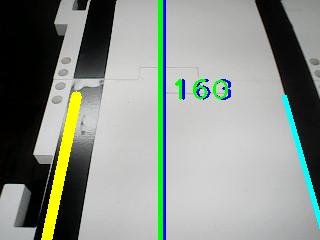

set


/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:18: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:18: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:18: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:18: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:18: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:18: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:18: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:18: RankWarning: Polyfit may be poorly conditioned


In [ ]:
if __name__=="__main__":
    
    time.sleep(1)
    module_num, motor = init_MR(bundle)
    time.sleep(1)
    print('MODI Connected!')
    print('motor 연결',motor)

  # Main
    cap = AICamera()
    print('카메라 연결',cap.is_opened())
 
    cap.set_window()
    print('set')
    
    lower_black = np.array([0, 0, 0])
    upper_black = np.array([20, 20, 20])
    
    #while(cap.is_opened()):
    for n in range(500):
        time.sleep(0.01)
        frame = cap.read()
        frame = cv2.flip(frame,1)
        

        canny_image = canny(frame)
        cropped_image = region_of_interest(canny_image)
        
        # 선분 검출 함수         
        lines = cv2.HoughLinesP(cropped_image, 1 , np.pi/180, 100, np.array([]), minLineLength=10, maxLineGap=1)      

        if str(type(lines)) == "<class 'NoneType'>":
            lines = [[[0, 0 ,0 ,0]]]
        elif len(lines) < 2:
            continue
        
        # 선분이 2개 검출될때 실행 
        if len(lines) >= 2 :
            averaged_lines = average_slope_intercept(frame, lines)
            find_vanishing(frame, averaged_lines)
            line_image = t_display_lines(frame, averaged_lines)
            vanishing_line, vanishing, center = find_vanishing(line_image, averaged_lines)
            combo_image = cv2.addWeighted(frame, 0.8, vanishing_line, 1, 1)
            find_way(vanishing, center)
        
        cap.show(frame)
            
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    print('finish')
    cv2.destroyAllWindows()